### KNN imputer for missing data

In [1]:

import pandas as pd
df = pd.read_csv('datasets/diabetes.csv')
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [2]:
data = df.copy()
print("Diabetes data set dimensions : {}".format(data.shape))

Diabetes data set dimensions : (768, 9)


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

In [4]:
data.columns[:-1]

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age'],
      dtype='object')

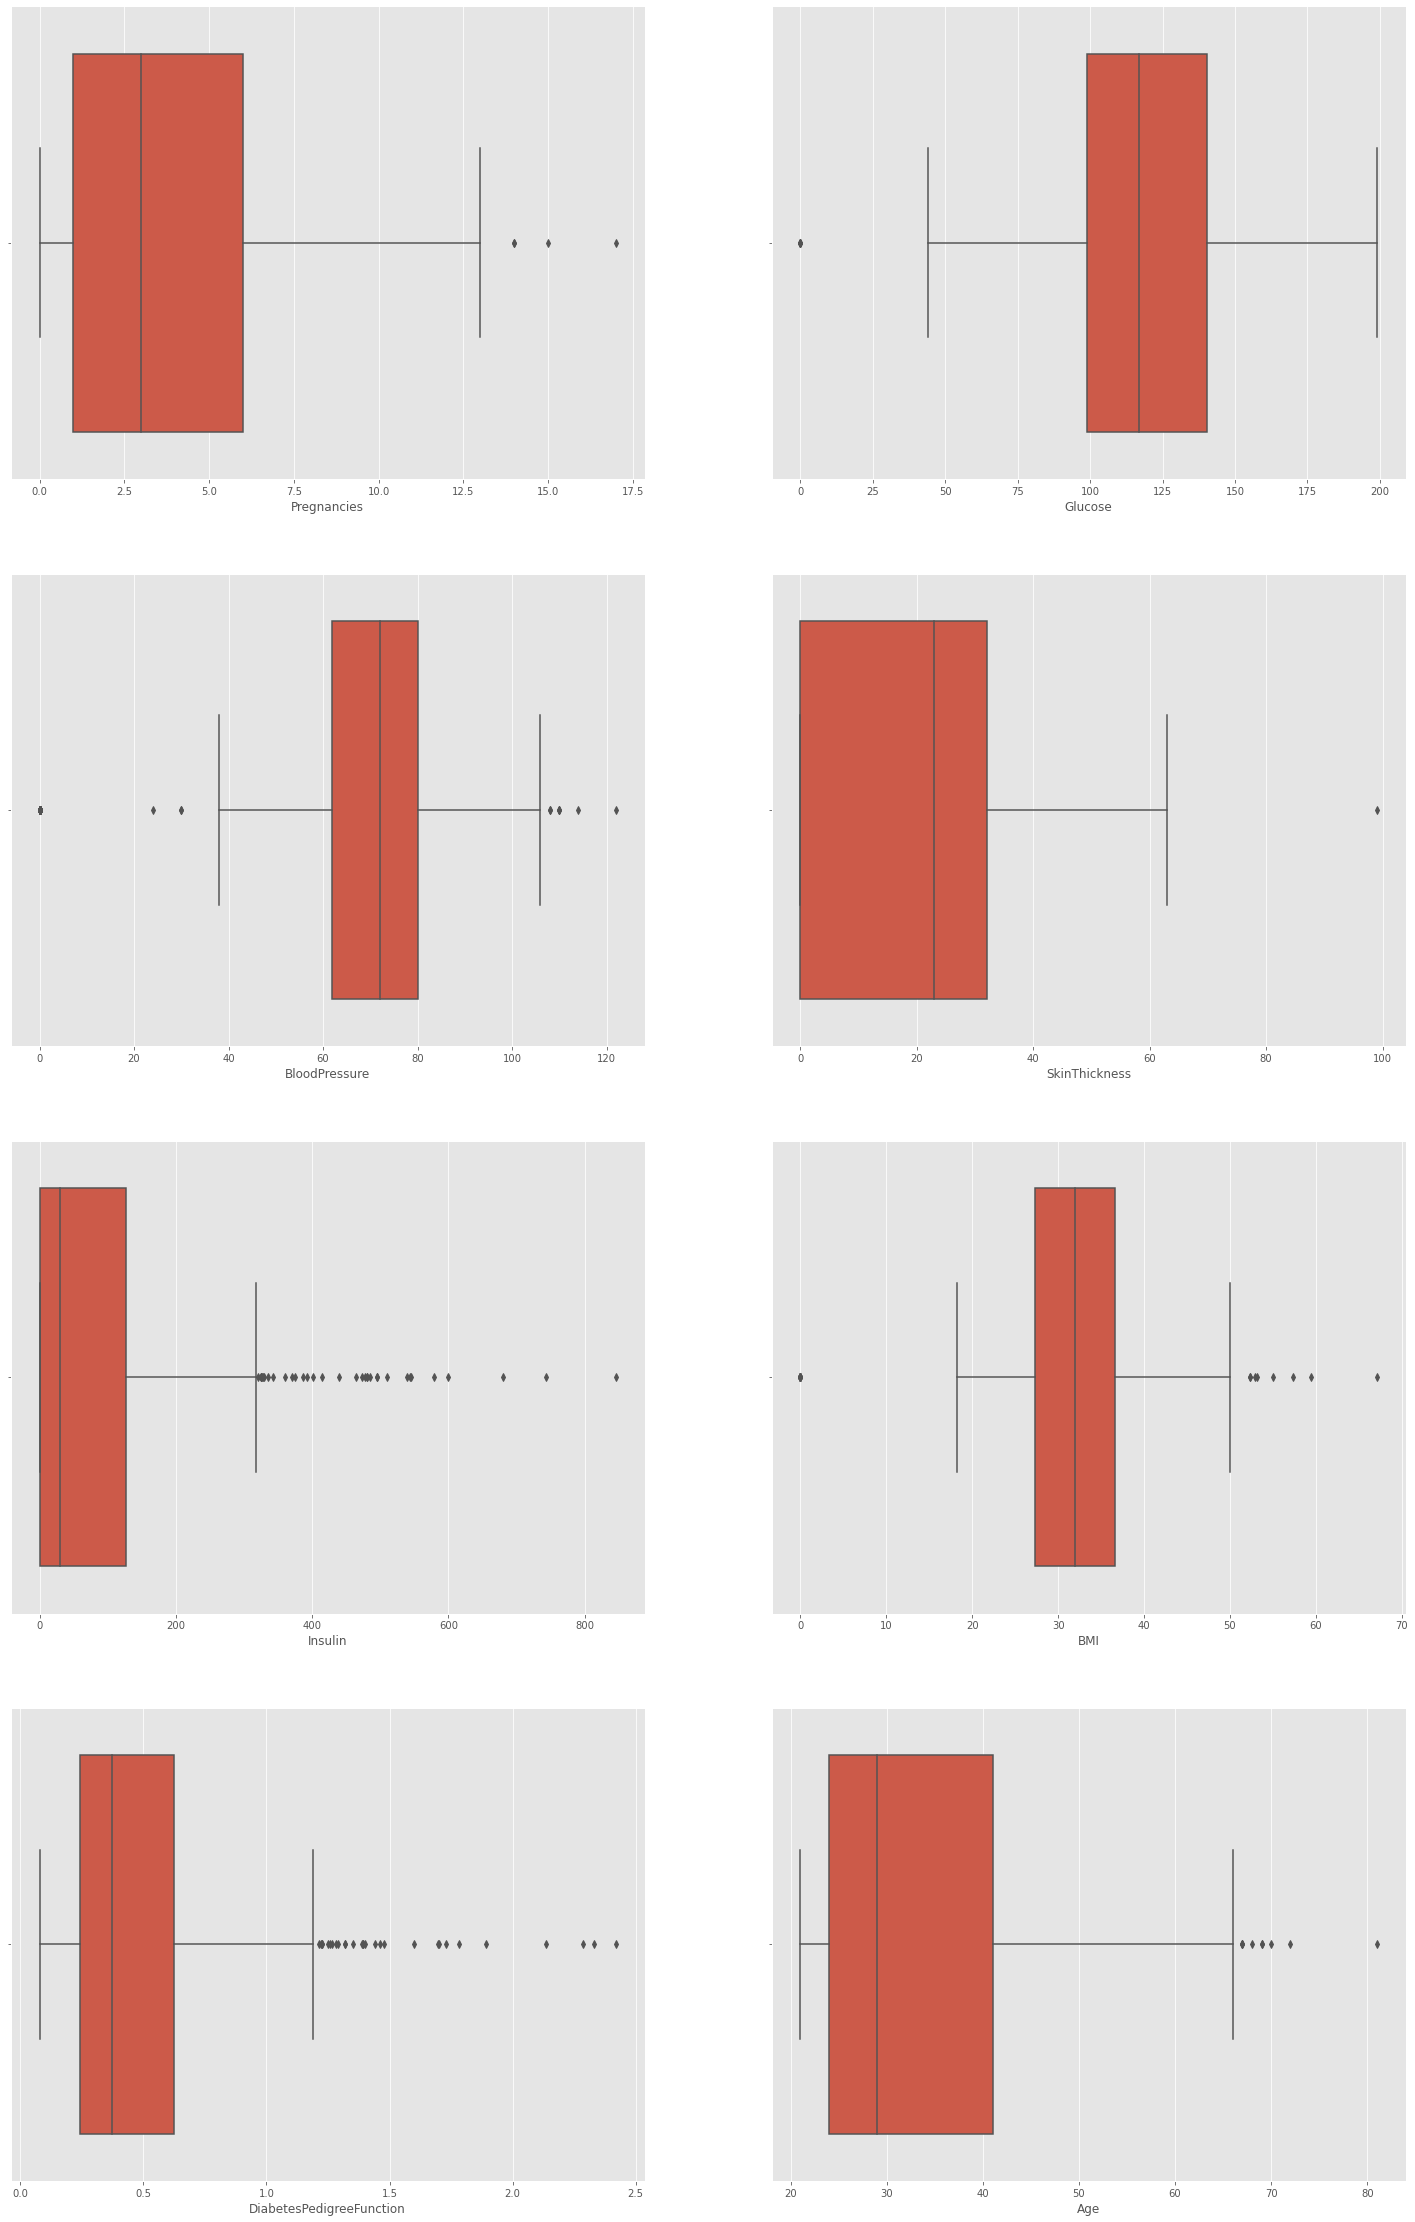

In [5]:
f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, figsize=(25, 40))
ax = [ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8]

for i, col in enumerate(data.columns[:-1]):
    sns.boxplot(x= data[col], ax= ax[i])

Here we observe that there are lot of outliers. So we use ensemble techniques like Decision Trees as it is non-sensitve to outliers and works well for less than 1k records.

In [6]:
data.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

* So there is ``no Null`` values from the dataset.

Now we extract features which has 0's as values except for first and last feature

In [7]:
data_col = data.columns[1: -1]
features = []
for col in data_col:
    if((data[col].unique() == 0).any()):
        features.append(col)
features        

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

* In reality we can't have ``zero's`` for **Glucose, BloodPressure, SkinThickness, Insulin, BMI** for diabetes prediction.

In [8]:
for col in features:
    filt = data[col] == 0
    info = data.loc[filt, col].value_counts()[0]
    print("{} has {} total number of zero's.\n".format(col, info))

Glucose has 5 total number of zero's.

BloodPressure has 35 total number of zero's.

SkinThickness has 227 total number of zero's.

Insulin has 374 total number of zero's.

BMI has 11 total number of zero's.



we observe that ``SkinThickness`` and ``Insulin`` has highest number of zeros.
* So we use **knn Imputer** Method to solve this problem which is good for replacing high number of zeros to **avoid** ``high variance`` rather than imputing with mean, mode or any other method.

In [9]:
import numpy as np

X = data.drop(columns = 'Outcome')
Y = data['Outcome']

In [10]:
#replace with np.nan to all features which has 0's
filt_0 = X[features] == 0
X[filt_0] = np.nan

X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33


In [11]:
X.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
dtype: int64

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
scaler = MinMaxScaler()

scaled_X = scaler.fit_transform(X)

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score


### Choose K-value
Lets plot recall_scores vs K-value

* Here we actually require **recall score** for diabetes prediction. Since here we are concentrating more on ``False Negative`` i.e if a female is diabetic but our model predicts that she is non-diabetic. so we try to reduce False Negative as much as possible. Moreover if a female is actually Non-diabetic but our model predicts that she is Diabetic, then she might go for further tests to clarify.

In [14]:
DTC_Mod = DecisionTreeClassifier(random_state= 0)

In [15]:
def Data_change(knn_Imp_X):
    inv_scaled_X = scaler.inverse_transform(knn_Imp_X)
    knn_Imp_X = pd.DataFrame(inv_scaled_X, columns = X.columns)

    cols = [col for col in X.columns if col not in ['BMI', 'DiabetesPedigreeFunction']]
    knn_Imp_X[cols] = np.where(knn_Imp_X[cols] > (knn_Imp_X[cols].astype(int) + 0.5), knn_Imp_X[cols].apply(np.ceil), knn_Imp_X[cols].apply(np.floor))
    knn_Imp_X[cols] = knn_Imp_X[cols].astype(int)
    
    return knn_Imp_X

In [16]:
recall_scores = []
for i in range(1, 60):
    knn_Imp = KNNImputer(n_neighbors= i, add_indicator= False)
    knn_Imp_X = knn_Imp.fit_transform(scaled_X)
    knn_Imp_X = Data_change(knn_Imp_X)
    recall_scores.append(cross_val_score(DTC_Mod, knn_Imp_X, Y, cv=10, scoring = 'recall').mean())


In [17]:
knn_Imp_X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,209,33.6,0.627,50
1,1,85,66,29,79,26.6,0.351,31
2,8,183,64,29,205,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [18]:
#recall_scores

Text(0, 0.5, 'recall_scores')

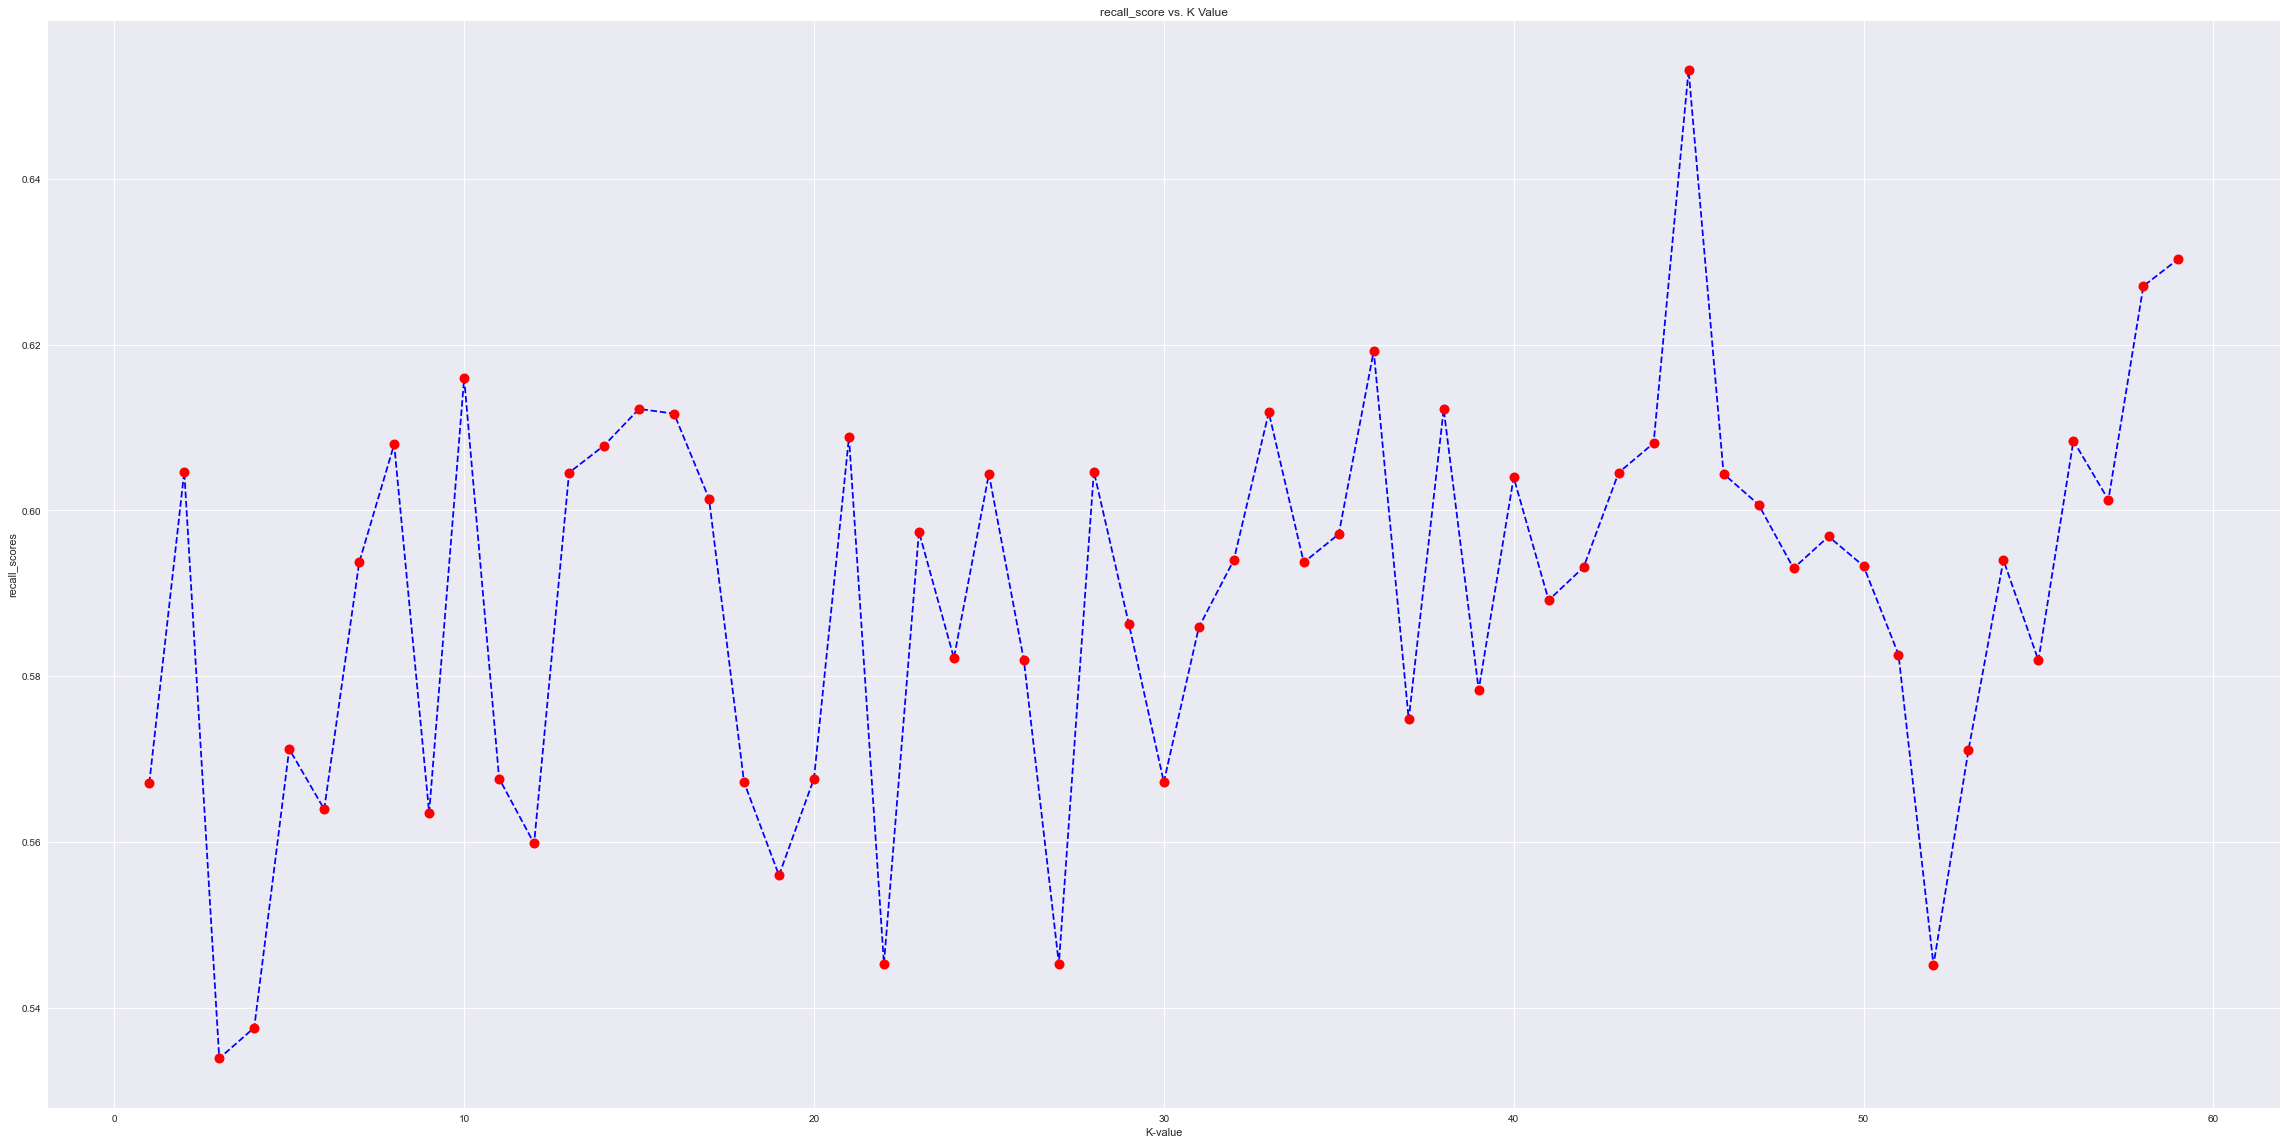

In [19]:
plt.style.use('seaborn')
plt.figure(figsize=(40, 20))
plt.plot(range(1,60), recall_scores ,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('recall_score vs. K Value')
plt.xlabel('K-value')
plt.ylabel('recall_scores')

In [20]:
max(recall_scores)

0.6531339031339031

In [21]:
k = [i for i,col in enumerate(recall_scores, start= 1) if(col == max(recall_scores))]
k

[45]

So we can choose **K = 45** for efficient recall_score

In [22]:
knn_Imp = KNNImputer(n_neighbors=45)
knn_Imp_X = knn_Imp.fit_transform(scaled_X)
inv_scaled_X = scaler.inverse_transform(knn_Imp_X)
knn_Imp_X = pd.DataFrame(inv_scaled_X, columns = X.columns)
cols = [col for col in X.columns if col not in ['BMI', 'DiabetesPedigreeFunction']]
knn_Imp_X[cols] = np.where(knn_Imp_X[cols] > (knn_Imp_X[cols].astype(int) + 0.5), knn_Imp_X[cols].apply(np.ceil), knn_Imp_X[cols].apply(np.floor))
knn_Imp_X[cols] = knn_Imp_X[cols].astype(int)


print("Cross Validation Recall Score = {}.".format(cross_val_score(DTC_Mod, knn_Imp_X, Y, cv=10, scoring = 'recall').mean()))

Cross Validation Recall Score = 0.6531339031339031.


In [23]:
knn_Imp_X.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,213,33.6,0.627,50
1,1,85,66,29,72,26.6,0.351,31
2,8,183,64,29,214,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33


In [24]:
knn_Imp_X.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
dtype: int64

Hence No null values are present in our data.

### save Dataset

In [25]:
knn_Imp_X.to_csv('datasets/KNN_Imputer_Diabetes.csv', index=False)